# Project: Bollinger Bands Mean Reversion Strategy

When prices move far from their average (more than a few standard deviations), they tend to revert.
We’ll go long when the price dips below the lower Bollinger Band (oversold) and short when it rises above the upper band (overbought).

We’ll only take Bollinger Band mean reversion signals when the RSI confirms oversold or overbought conditions — improving signal quality and avoiding “catching falling knives.”

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import logging
from datetime import datetime

%load_ext autoreload
%autoreload 2

## Data Setup

In [2]:
# Initialize variables
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-21')

In [3]:
# Download stock data from YFinance
df = yf.download(ticker, start=start_date, end=end_date)
df = df.xs(ticker, axis=1, level=1)['Close'].to_frame()

df.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2025-11-14,272.410004
2025-11-17,267.459991
2025-11-18,267.440002
2025-11-19,268.559998
2025-11-20,266.250000


## Set Indicators

In [4]:
window = 20 # The number of periods to calculate the moving average over
num_std = 2 # The number of standard deviations from the mean to set upper and lower bounds
rsi_period = 14 # The number of periods to calculate the Relative Strength Index over

In [5]:
df['MA'] = df['Close'].rolling(window).mean() # Moving average
df['STD'] = df['Close'].rolling(window).std() # Standard deviation
df['Upper'] = df['MA'] + num_std * df['STD'] # Upper bound x number of standard deviations from the mean
df['Lower'] = df['MA'] - num_std * df['STD'] # Lower bound x number of standard deviations from the mean

In [6]:
# RSI Calculation

delta = df['Close'].diff() # Change in price from the previous close
gain = np.where(delta > 0, delta, 0) # Positive price movements
loss = np.where(delta < 0, -delta, 0) # Negative price movements
avg_gain = pd.Series(gain).rolling(rsi_period).mean() # The average positive price movement over a rolling window
avg_loss = pd.Series(loss).rolling(rsi_period).mean() # The average negative price movement over a rolling window
rs = (avg_gain / avg_loss).values # Average gain/loss over a rolling window
df['RSI'] = 100 - (100 / (1 + rs)) # Relative Strength Index (RSI > 70 indicates an OVERBOUGHT stock & RSI < 30 indicates an OVERSOLD stock)

df.dropna(inplace=True)
df.head()


,Close,MA,STD,Upper,Lower,RSI
Date,,,,,,
2015-01-30,25.973391,24.528299,0.796546,26.121391,22.935206,58.434263
2015-02-02,26.299294,24.631386,0.885396,26.402177,22.860595,66.039709
2015-02-03,26.303715,24.768835,0.922076,26.612987,22.924683,64.899223
2015-02-04,26.505459,24.916260,0.953299,26.822858,23.009661,66.956173
2015-02-05,26.694645,25.056628,0.999384,27.055396,23.057860,75.500212


In [7]:
def set_indicators(df,
                   window: int = 20,
                   num_std: int = 2,
                   rsi_period: int = 14):
    
    '''
        Set initial indicators for the bollinger with RSI strategy
    '''

    df = df.copy() # Ensure we are updating a copy and not directly updating the referenced dataframe

    df['MA'] = df['Close'].rolling(window).mean() # Moving average
    df['STD'] = df['Close'].rolling(window).std() # Standard deviation
    df['Upper'] = df['MA'] + num_std * df['STD'] # Upper bound x number of standard deviations from the mean
    df['Lower'] = df['MA'] - num_std * df['STD'] # Lower bound x number of standard deviations from the mean

    delta = df['Close'].diff() # Change in price from the previous close
    gain = np.where(delta > 0, delta, 0) # Positive price movements
    loss = np.where(delta < 0, -delta, 0) # Negative price movements
    avg_gain = pd.Series(gain).rolling(rsi_period).mean() # The average positive price movement over a rolling window
    avg_loss = pd.Series(loss).rolling(rsi_period).mean() # The average negative price movement over a rolling window
    rs = (avg_gain / avg_loss).values # Average gain/loss over a rolling window
    df['RSI'] = 100 - (100 / (1 + rs)) # Relative Strength Index (RSI > 70 indicates an OVERBOUGHT stock & RSI < 30 indicates an OVERSOLD stock)

    df.dropna(inplace=True) # We wont have complete data for the initial number of rolling moving avergae and/or RSI periods
    
    return df

In [8]:
df = set_indicators(df)

## Trading Logic & Backtesting

Conditions:
* Long when price < lower band AND RSI < 30 (oversold)
* Short when price > upper band AND RSI > 70 (overbought)
* Exit when price crosses back towards MA

In [9]:
def bollinger(df,
              investment: float = 100.00,
              exit_method: str = 'bound',
              trade_commission: float = 0.00,
              log_trades: bool = True,
              return_trades: bool = False) -> pd.DataFrame:
    
    '''
        Function to run a full backtest on the bollinger mean reversion & RSI method with optional exit methods
        
        Parameters:
            df_backtest: 
                Pandas DataFrame containing periodic close price data

            exit_method: Optional exit strategies, default = "bound":
                Parameter options:
                    * bound - Exit LONG trades when the price crosses the lower bollinger band from below & Exit SHORT trades when the price crosses the upper bollinger band from above
                    * ma - Exit LONG & SHORT trades when the price touches the moving average
                    * single - Exit position after a single period of trading

            trade_fee: 
                Optional inclusion of trade fee losses

            log_trades, default = True
                Option to write individual trade information to a trade report file

            return_trades, default = False
                Option to return a second dataframe containing trade report data

        Returns:
            pandas DataFrame
    '''

    df_backtest = df.copy()

    df_backtest['BuyHold'] = df_backtest['Close'].pct_change()
    df_backtest['BuyHoldCurve'] = (1 + df_backtest['BuyHold']).cumprod()
    # Monetary returns on initial investment
    df_backtest['BuyHoldValue'] = round((df_backtest['BuyHold'] + 1).fillna(investment).cumprod(),2)

    if exit_method not in ['bound', 'ma', 'single']:
        raise Exception('exit_method must be one of: "bound", "ma", "single"')

    position = 0.0 # 1 = LONG, -1 = SHORT, 0 = FLAT
    # df_backtest['Position'] = position # Initial FLAT (No position)
    trade_num = 0
    last_trade_num = 0
    # df_backtest['Trade_Num'] = trade_num # Track all indivdual trades

    for i in range(1, len(df_backtest)):

        # Previous closing period will signal the current periods position
        prev_price = df_backtest['Close'].iloc[i-1] # Previous closing price
        prev_ma = df_backtest['MA'].iloc[i-1] # Previous closing moving average
        prev_rsi = df_backtest['RSI'].iloc[i-1] # Previous closing RSI
        prev_upper = df_backtest['Upper'].iloc[i-1] # Previous closing upper bollinger limit
        prev_lower = df_backtest['Lower'].iloc[i-1] # Previous closing lower bollinger limit

        if position != 0:
            last_trade_num = trade_num

        # Only hold position for a single period of trading
        if exit_method == 'single':
            position = 0

        # ENTRY RULES
        if position == 0: # FLAT
            if prev_price < prev_lower and prev_rsi < 30: # If price crosses the lower band & stock is undersold
                position = 1 # Open a LONG position
                trade_num = last_trade_num + 1 # Flag new trade position
            elif prev_price > prev_upper and prev_rsi > 70: # If price crosses the upper band & stock is oversold
                position = -1 # Open a SHORT position
                trade_num = last_trade_num + 1 # Flag new trade position
        # EXIT RULES
        else:
            match exit_method:
                case 'bound':
                    if position == 1 and prev_price > prev_lower: # If position is LONG and price crosses below the upper bollinger limit
                        position = 0 # Exit LONG position
                        trade_num = 0
                        
                    elif position == -1 and prev_price < prev_upper: # If position is SHORT and price crosses above the lower bollinger limit 
                        position = 0 # Exit SHORT position
                        trade_num = 0

                case 'ma':
                    if position == 1 and prev_price >= prev_ma: #and prev_price > prev_ma:
                        position = 0 # Exit LONG when price crosses below MA
                        trade_num = 0
                    elif position == -1 and prev_price <= prev_ma: #and prev_price < prev_ma:
                        position = 0 # Exit SHORT when price crosses above MA
                        trade_num = 0

        # Period parameters will signal the position for the next trading period
        df_backtest.loc[df_backtest.index[i-1], 'Signal'] = position
        # Indicate whether we are currently in a LONG or SHORT position
        df_backtest.loc[df_backtest.index[i], 'Position'] = float(position)
        # Track trade number
        df_backtest.loc[df_backtest.index[i], 'TradeNum'] = trade_num

    df_backtest['Signal'] = df_backtest['Signal'].fillna(0)
    df_backtest['TradeNum'] = df_backtest['TradeNum'].replace({0: np.nan}).bfill(limit=1) # Backfill 1 period as the trade is entered when signalled
    # Strategy returns before accounting for transaction losses, such as fees and slippage
    df_backtest['StrategyGross'] = df_backtest['Position'] * df_backtest['BuyHold'] # We only benefit from price movements when in position
    # Trade fees are applied on both entry and exit of trades
    df_backtest['TradeFee'] = - abs(df_backtest['Signal'] - df_backtest['Position']) * trade_commission
    # Total strategy returns after accounting for transaction losses
    df_backtest['Strategy'] = (1 + df_backtest['StrategyGross']) * (1 + df_backtest['TradeFee']) - 1
    df_backtest['StrategyCurve'] = (1 + df_backtest['Strategy']).cumprod()
    # Monetary returns on initial investment
    df_backtest['StrategyValue'] = round((df_backtest['Strategy'] + 1).fillna(investment).cumprod(),2)

    df_backtest['TransactionCost'] = round(df_backtest['TradeFee'] * df_backtest['StrategyValue'].shift(),2)
    
    return df_backtest

# bollinger(df, exit_method='bound', trade_commission=0, investment=100)

In [10]:
# Runing a backtest on the bollinger method using a bound exit strategy, not accounting for any trading fee losses
df_backtest = bollinger(df, exit_method='bound', trade_commission=0.00025)
df_backtest

,Close,MA,STD,Upper,Lower,RSI,BuyHold,BuyHoldCurve,BuyHoldValue,Signal,Position,TradeNum,StrategyGross,TradeFee,Strategy,StrategyCurve,StrategyValue,TransactionCost
Date,,,,,,,,,,,,,,,,,,
2015-02-27,28.590912,27.804208,1.172960,30.150129,25.458288,71.262841,NaN,NaN,100.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN
2015-03-02,28.731123,27.942095,1.106629,30.155352,25.728838,71.056162,0.004904,1.004904,100.49,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-03-03,28.791218,28.066691,1.050805,30.168302,25.965081,68.150328,0.002092,1.007006,100.70,0.0,0.0,NaN,0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-03-04,28.608717,28.181941,0.970613,30.123167,26.240716,60.066069,-0.006339,1.000623,100.06,0.0,0.0,NaN,-0.0,-0.0,0.0,1.000000,100.00,-0.0
2015-03-05,28.134640,28.263400,0.887297,30.037994,26.488807,49.866375,-0.016571,0.984041,98.40,0.0,0.0,NaN,-0.0,-0.0,0.0,1.000000,100.00,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,272.410004,268.112178,4.713296,277.538771,258.685585,60.984026,-0.001978,9.527853,952.79,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0
2025-11-17,267.459991,268.385876,4.492599,277.371074,259.400679,47.135420,-0.018171,9.354721,935.47,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0
2025-11-18,267.440002,268.632101,4.284036,277.200173,260.064030,45.384538,-0.000075,9.354021,935.40,0.0,0.0,NaN,-0.0,-0.0,0.0,1.245907,124.59,-0.0


In [11]:
df_trades = pd.read_csv('reports/trade_log.csv', index_col='Trade Num')
df_trades

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,GrossReturn,TransactionCost,NetReturn,DurationDays
Trade Num,,,,,,,,,
1,2015-04-28,2015-04-29,Short,29.523457,29.058304,0.015755,0.000158,0.015598,1
2,2015-07-10,2015-07-13,Long,26.835199,27.552618,0.026734,0.000267,0.026467,3
3,2015-08-05,2015-08-06,Long,25.621614,25.791470,0.006629,0.000066,0.006563,1
4,2015-10-26,2015-10-27,Short,26.734406,25.881271,0.031911,0.000319,0.031592,1
5,2015-12-16,2015-12-17,Long,24.912066,25.103714,0.007693,0.000077,0.007616,1
...,...,...,...,...,...,...,...,...,...
96,2025-03-11,2025-03-17,Long,226.704773,212.762451,-0.061500,0.000615,-0.062115,6
97,2025-04-08,2025-04-10,Long,180.841614,198.172348,0.095834,0.000958,0.094875,2
98,2025-07-03,2025-07-08,Short,211.993668,209.508896,0.011721,0.000117,0.011604,5


In [12]:
def get_trade_stats(data):

    df_group = data.copy()

    df_group['StrategyValueShifted'] = df_group['StrategyValue'].shift()

    df_group = df_group.reset_index().groupby('TradeNum').agg({'Date': ['first', 'last'],
                                                               'Position': 'last',
                                                               'Close': ['first', 'last'],
                                                               'StrategyCurve': 'last',
                                                               'TransactionCost': 'sum',
                                                               'StrategyValueShifted': 'first',
                                                               'StrategyValue': 'last'})

    df_group.columns=['EntryDate','ExitDate','Direction','EntryPrice','ExitPrice','NetReturn','TransactionFee', 'InvestmentOpen', 'InvestmentClose']
    df_group['PnL'] = df_group['InvestmentClose'] - df_group['InvestmentOpen']
    df_group['DurationDays'] = (df_group['ExitDate'] - df_group['EntryDate']).dt.days
    df_group['Direction'] = df_group['Direction'].replace({1:'Long', -1:'Short'})
    df_group['NetReturn'] = df_group['NetReturn'].pct_change().fillna(df_group['NetReturn'].iloc[0] - 1) + 1
    
    return df_group
    # return data

get_trade_stats(df_backtest)

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,NetReturn,TransactionFee,InvestmentOpen,InvestmentClose,PnL,DurationDays
TradeNum,,,,,,,,,,,
1.0,2015-04-27,2015-04-28,Short,29.523460,29.058300,1.015248,-0.04,100.00,101.52,1.52,1
2.0,2015-07-09,2015-07-10,Long,26.835199,27.552618,1.026221,-0.06,101.52,104.19,2.67,1
3.0,2015-08-04,2015-08-05,Long,25.621613,25.791471,1.006126,-0.06,104.19,104.83,0.64,1
4.0,2015-10-23,2015-10-26,Short,26.734404,25.881271,1.031396,-0.06,104.83,108.12,3.29,3
5.0,2015-12-15,2015-12-16,Long,24.912062,25.103704,1.007189,-0.06,108.12,108.89,0.77,1
...,...,...,...,...,...,...,...,...,...,...,...
96.0,2025-03-10,2025-03-14,Long,226.704773,212.762466,0.938031,-0.06,118.03,110.72,-7.31,4
97.0,2025-04-07,2025-04-09,Long,180.841614,198.172348,1.095286,-0.06,110.72,121.27,10.55,2
98.0,2025-07-02,2025-07-07,Short,211.993668,209.508896,1.011039,-0.06,121.27,122.60,1.33,5


## Performance Evaluation

In [13]:
def performance_metrics(df_performance,
                        performance_on: str | list[str] = ['Strategy', 'BuyHold'],
                        return_dict: bool = False) -> pd.DataFrame | dict:

    '''
    Function to evaluate backtested performance on given strategies
    '''

    performance_dict = {}

    if type(performance_on) == str:
        performance_on = [performance_on]

    for method in performance_on:

        strategy = df_performance[method]
        strat_total_return = df_performance[f'{method}Curve'].iloc[-1] - 1
        strat_cagr = (df_performance[f'{method}Curve'].iloc[-1]) ** (252 / len(df_performance)) - 1
        strat_risk = strategy.std() * np.sqrt(252)
        strat_return = strategy.mean() * 252
        strat_sharpe = strat_return / strat_risk
        strat_max_dd = (df_performance[f'{method}Curve'].cummax() - df_performance[f'{method}Curve']).max()

        performance_dict[method] = {
            'Total Return': f'{strat_total_return:.2%}',
            'Annual Return': round(strat_return,2),
            'Annual Risk': round(strat_risk,2),
            'Sharpe Ratio': round(strat_sharpe, 2),
            'CAGR': f'{strat_cagr:.2%}',
            'Max Drawdown': f'{strat_max_dd:.2%}'
            }
        
    if return_dict:
        return performance_dict
    else:
        return pd.DataFrame.from_dict(performance_dict, orient='Index')

In [14]:
performance_metrics(df_backtest)

,Total Return,Annual Return,Annual Risk,Sharpe Ratio,CAGR,Max Drawdown
Strategy,24.59%,0.02,0.09,0.27,2.07%,18.28%
BuyHold,831.24%,0.25,0.29,0.86,23.14%,300.87%


### Trade Statistics

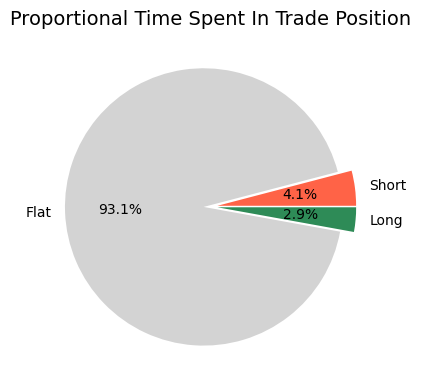

In [15]:
fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)

ax.set_title('Proportional Time Spent In Trade Position', fontsize=14)
ax.pie(df_backtest.groupby('Position').count()['Close'],
           labels=['Short', 'Flat', 'Long'],
           autopct='%1.1f%%',
           colors=['tomato', 'lightgrey', 'seagreen'],
           explode=[0.05, 0.05, 0.05],
           shadow=False)

plt.show;

In [16]:
df_trades = get_trade_stats(df_backtest)
df_trades

,EntryDate,ExitDate,Direction,EntryPrice,ExitPrice,NetReturn,TransactionFee,InvestmentOpen,InvestmentClose,PnL,DurationDays
TradeNum,,,,,,,,,,,
1.0,2015-04-27,2015-04-28,Short,29.523460,29.058300,1.015248,-0.04,100.00,101.52,1.52,1
2.0,2015-07-09,2015-07-10,Long,26.835199,27.552618,1.026221,-0.06,101.52,104.19,2.67,1
3.0,2015-08-04,2015-08-05,Long,25.621613,25.791471,1.006126,-0.06,104.19,104.83,0.64,1
4.0,2015-10-23,2015-10-26,Short,26.734404,25.881271,1.031396,-0.06,104.83,108.12,3.29,3
5.0,2015-12-15,2015-12-16,Long,24.912062,25.103704,1.007189,-0.06,108.12,108.89,0.77,1
...,...,...,...,...,...,...,...,...,...,...,...
96.0,2025-03-10,2025-03-14,Long,226.704773,212.762466,0.938031,-0.06,118.03,110.72,-7.31,4
97.0,2025-04-07,2025-04-09,Long,180.841614,198.172348,1.095286,-0.06,110.72,121.27,10.55,2
98.0,2025-07-02,2025-07-07,Short,211.993668,209.508896,1.011039,-0.06,121.27,122.60,1.33,5


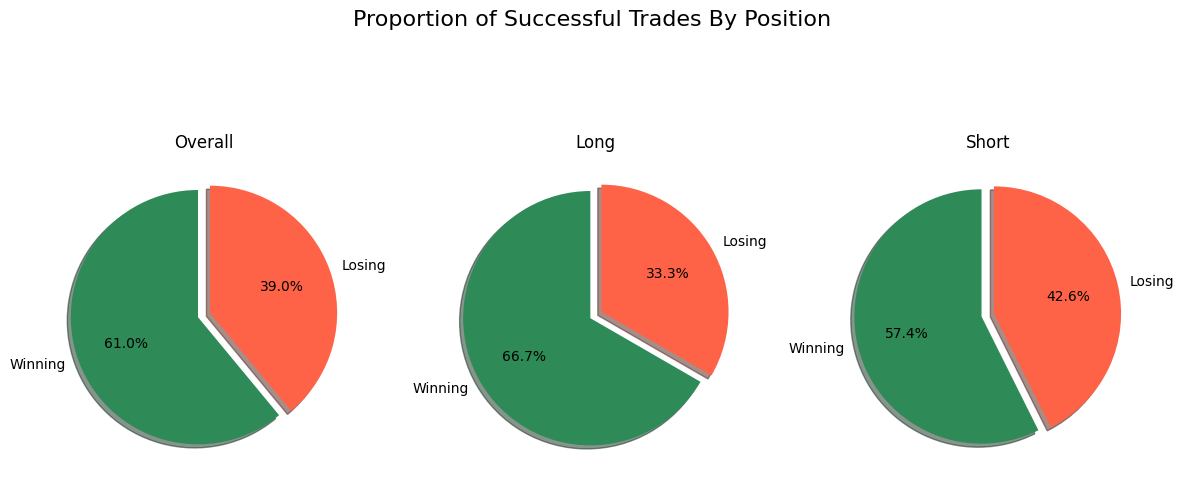

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), tight_layout=True)

fig.suptitle('Proportion of Successful Trades By Position', fontsize=16)

ax[0].set_title('Overall', fontsize=12)
ax[0].pie((df_trades['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[1].set_title('Long', fontsize=12)
ax[1].pie((df_trades[df_trades['Direction']=='Long']['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

ax[2].set_title('Short', fontsize=12)
ax[2].pie((df_trades[df_trades['Direction']=='Short']['NetReturn'] > 1).value_counts(),
           labels=['Winning', 'Losing'],
           autopct='%1.1f%%',
           colors=['seagreen', 'tomato'],
           explode=[0.05, 0.05],
           shadow=True,
           startangle=90)

plt.show()

## Visualization

### Bollinger Bands Plot With Long/Short Signals

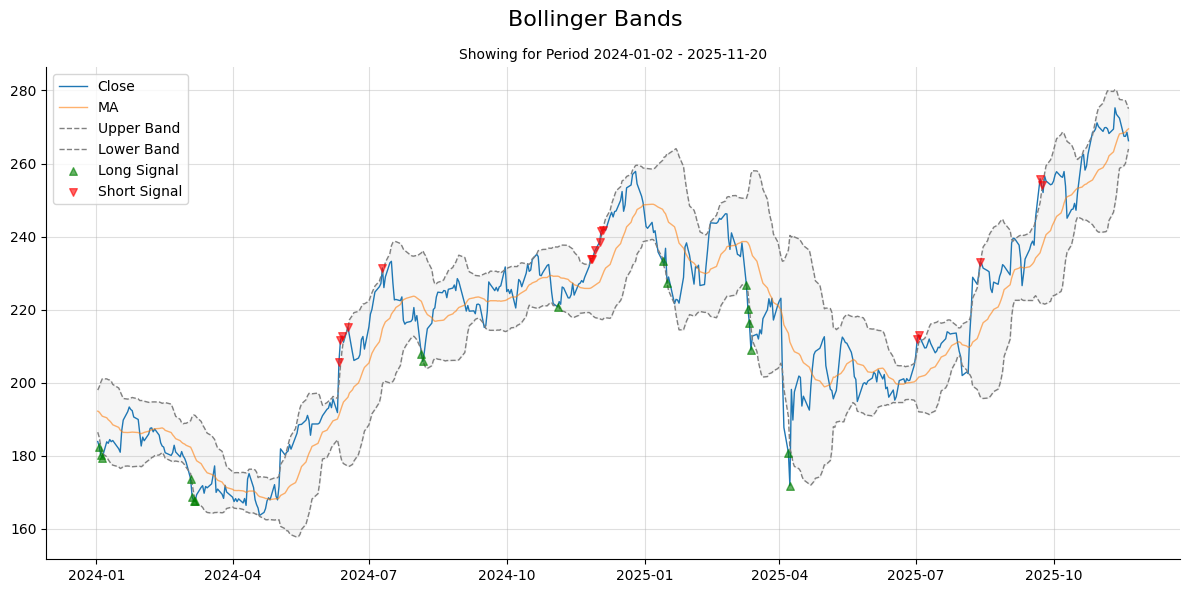

In [18]:
def plot_bands(df):

    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    fig.suptitle(f'Bollinger Bands', fontsize=16)
    ax.set_title(f'Showing for Period {df.index[0].date()} - {df.index[-1].date()}', fontsize=10)

    ax.plot(df['Close'], label = 'Close', linewidth=1)
    ax.plot(df['MA'], label = 'MA', linewidth=1, alpha=0.6)
    ax.plot(df['Upper'], label = 'Upper Band', linestyle='--', color='grey', linewidth=1)
    ax.plot(df['Lower'], label = 'Lower Band', linestyle='--', color='grey', linewidth=1)
    ax.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.075)

    ax.scatter(x=df[df['Signal']==1].index, y=df[df['Signal']==1]['Close'].loc[df[df['Signal']==1].index], marker='^', s=30, color='Green', label='Long Signal', zorder=4, alpha=0.6)
    ax.scatter(x=df[df['Signal']==-1].index, y=df[df['Signal']==-1]['Close'].loc[df[df['Signal']==-1].index], marker='v', s=30, color='red', label='Short Signal', zorder=4, alpha=0.6)

    ax.grid(True, alpha=0.4)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='best')

    return plt.show()

plot_bands(df_backtest.loc['2024':])

### RSI Plot

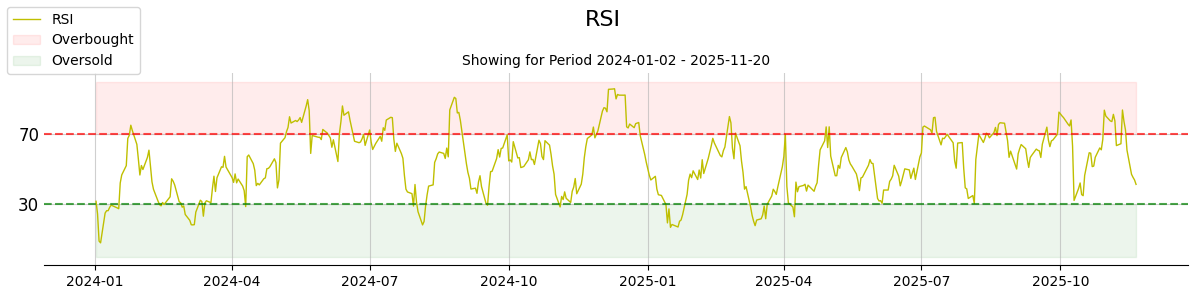

In [19]:
def plot_rsi(df):

    fig, ax = plt.subplots(figsize=(12,3), tight_layout=True)
    fig.suptitle('RSI', fontsize=16)
    ax.set_title(f'Showing for Period {df.index[0].date()} - {df.index[-1].date()}', fontsize=10)
    ax.plot(df['RSI'], label = 'RSI', linewidth=1, color='y')
    ax.axhline(70, color="r", linestyle="--", alpha=0.7)
    ax.axhline(30, color="g", linestyle="--", alpha=0.7)
    ax.fill_between(df.index, 70, 100, color='r', alpha=0.075, label='Overbought')
    ax.fill_between(df.index, 0, 30, color='g', alpha=0.075, label='Oversold')

    ax.grid(True, alpha=0.6)

    ax.spines[['top', 'right', 'left']].set_visible(False)
    fig.legend(loc='outside upper left')
    
    ax.set_yticks([30,70])
    ax.tick_params(axis='y', labelsize=12, length=0)

    return plt.show()

plot_rsi(df_backtest.loc['2024':])


### Strategy vs Buy&Hold

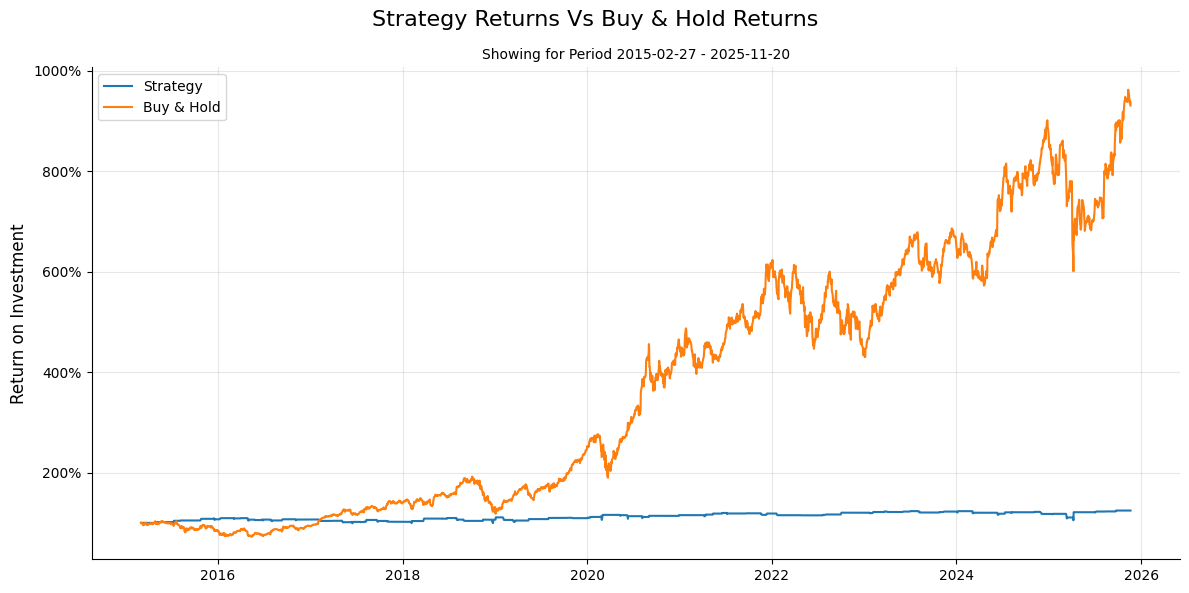

In [20]:
def plot_return_curve(df_curve):

    fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
    fig.suptitle('Strategy Returns Vs Buy & Hold Returns', fontsize=16)
    ax.set_title(f'Showing for Period {df_curve.index[0].date()} - {df_curve.index[-1].date()}', fontsize=10)    
    ax.plot(100*df_curve['StrategyCurve'], label='Strategy')
    ax.plot(100*df_curve['BuyHoldCurve'], label='Buy & Hold')
    ax.yaxis.set_major_formatter('{x:1.0f}%')
    ax.set_ylabel('Return on Investment', fontsize=12)

    ax.grid(True, alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend(loc='best')

    return plt.show()

plot_return_curve(df_backtest)

## What if we added more stocks?

In [174]:
# Initialize variables
ticker = 'AAPL'#, 'MSFT', 'AMZN', 'NVDA', 'GOOG']
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-21')

In [175]:
# Download stock data from YFinance
df = yf.download(ticker, start=start_date, end=end_date)
#df = df.droplevel(axis=1, level=1)['Close']#.to_frame()
df.dropna(inplace=True)

df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-11-14,272.410004,275.959991,269.600006,271.049988,47431300
2025-11-17,267.459991,270.489990,265.730011,268.820007,45018300
2025-11-18,267.440002,270.709991,265.320007,269.989990,45677300
2025-11-19,268.559998,272.209991,265.500000,265.529999,40424500
2025-11-20,266.250000,275.429993,265.920013,270.829987,45823600


In [176]:
def calc_returns(df,
                 name: str = 'Return',
                 investment: float = 100.00):
    
    df = df.copy()

    df[name] = df['Close'].pct_change()
    df[f'{name}Curve'] = (1 + df[name]).cumprod()
    # Monetary returns on initial investment
    df[f'{name}Value'] = round((df[name] + 1).fillna(investment).cumprod(),2)

    return df


In [177]:
backtest_dict = {}

for ticker in df.columns.levels[1]:
    df_ticker = df.xs(ticker, axis=1, level=1)['Close'].to_frame()
    df_ticker = set_indicators(df_ticker)
    df_ticker = calc_returns(df_ticker)


    # Calculate signals for strategy

    position = 0.0 # 1 = LONG, -1 = SHORT, 0 = FLAT
    # df_backtest['Position'] = position # Initial FLAT (No position)
    trade_num = 0
    last_trade_num = 0
    # df_backtest['Trade_Num'] = trade_num # Track all indivdual trades

    for i in range(1, len(df_ticker)):

        # Previous closing period will signal the current periods position
        prev_price = df_ticker['Close'].iloc[i-1] # Previous closing price
        prev_ma = df_ticker['MA'].iloc[i-1] # Previous closing moving average
        prev_rsi = df_ticker['RSI'].iloc[i-1] # Previous closing RSI
        prev_upper = df_ticker['Upper'].iloc[i-1] # Previous closing upper bollinger limit
        prev_lower = df_ticker['Lower'].iloc[i-1] # Previous closing lower bollinger limit

        if position != 0:
            last_trade_num = trade_num

        # # Only hold position for a single period of trading
        # if exit_method == 'single':
        #     position = 0

        # ENTRY RULES
        if position == 0: # FLAT
            if prev_price < prev_lower and prev_rsi < 30: # If price crosses the lower band & stock is undersold
                position = 1 # Open a LONG position
                trade_num = last_trade_num + 1 # Flag new trade position
            elif prev_price > prev_upper and prev_rsi > 70: # If price crosses the upper band & stock is oversold
                position = -1 # Open a SHORT position
                trade_num = last_trade_num + 1 # Flag new trade position
        # EXIT RULES
        else:
        #     match exit_method:
        #         case 'bound':
            if position == 1 and prev_price > prev_lower: # If position is LONG and price crosses below the upper bollinger limit
                position = 0 # Exit LONG position
                trade_num = 0
                
            elif position == -1 and prev_price < prev_upper: # If position is SHORT and price crosses above the lower bollinger limit 
                position = 0 # Exit SHORT position
                trade_num = 0

                # case 'ma':
                #     if position == 1 and prev_price >= prev_ma: #and prev_price > prev_ma:
                #         position = 0 # Exit LONG when price crosses below MA
                #         trade_num = 0
                #     elif position == -1 and prev_price <= prev_ma: #and prev_price < prev_ma:
                #         position = 0 # Exit SHORT when price crosses above MA
                #         trade_num = 0

        # Period parameters will signal the position for the next trading period
        df_ticker.loc[df_ticker.index[i-1], 'Signal'] = position
        # Indicate whether we are currently in a LONG or SHORT position
        df_ticker.loc[df_ticker.index[i], 'Position'] = float(position)
        # Track trade number
        df_ticker.loc[df_ticker.index[i], 'TradeNum'] = trade_num

    df_ticker['Signal'] = df_ticker['Signal'].fillna(0)
    df_ticker['Position'] = df_ticker['Position'].fillna(0)
    df_ticker['TradeNum'] = df_ticker['TradeNum'].replace({0: np.nan}).bfill(limit=1) # Backfill 1 period as the trade is entered when signalled


    backtest_dict[ticker] = df_ticker

df_backtest = pd.concat(backtest_dict.values(), axis=1, keys=backtest_dict.keys())

idx = pd.IndexSlice

# # Position sizing
# # If indicators signal that we should enter positions simultaneously across multiple stocks then we need to adjust position size
df_backtest.loc[:, idx[:, ['Position']]] = df_backtest.loc[:, idx[:, ['Position']]].div((df_backtest.loc[:, idx[:, ['Position']]]!=0).sum(axis=1), axis=0).fillna(0)
df_backtest.loc[:, idx[:, ['Signal']]] = df_backtest.loc[:, idx[:, ['Signal']]].div((df_backtest.loc[:, idx[:, ['Signal']]]!=0).sum(axis=1), axis=0).fillna(0)

# The investment lost in trade fees
df_backtest = df_backtest.join((-abs(df_backtest.loc[:, idx[:, ['Signal']]].sub(df_backtest.loc[:, idx[:, ['Position']]].values))).mul(0.0000).rename(columns = {'Signal': 'TradeFee'}))

# Gross strategy returns based on position sizing, not including any deductions due to transaction costs and/or slippage
df_backtest = df_backtest.join((df_backtest.loc[:, idx[:, ['Return']]].mul(df_backtest.loc[:, idx[:, ['Position']]].values)).rename(columns = {'Return': 'StrategyGross'}))

# Total strategy returns, accounting for losses due to transaction costs and/or slippage
df_backtest = df_backtest.join(((1 + df_backtest.loc[:, idx[:, ['StrategyGross']]]).mul((1 + df_backtest.loc[:, idx[:, ['TradeFee']]]).values)).sub(1).rename(columns = {'StrategyGross': 'Strategy'}))

# Cumulative strategy returns
df_backtest = df_backtest.join(((1 + df_backtest.loc[:, idx[:, ['Strategy']]]).cumprod()).rename(columns = {'Strategy': 'StrategyCurve'}))

# Calculate overall strategy returns
df_backtest.loc[:, idx['Strategy', 'Strategy']] = df_backtest.loc[:, idx[:, ['Strategy']]].sum(axis=1)
df_backtest.loc[:, idx['Strategy', 'StrategyCurve']] = (1 + df_backtest.loc[:, idx['Strategy', 'Strategy']]).cumprod()
df_backtest.loc[:, idx['Strategy', 'StrategyValue']] = df_backtest.loc[:, idx['Strategy', 'StrategyCurve']] * 100

# Group columns by ticker
df_backtest.sort_index(axis=1, level=0, sort_remaining=False, inplace=True)

In [178]:
df_backtest

AAPL                                                \
                 Close          MA       STD       Upper       Lower   
Date                                                                   
2015-01-30   25.973391   24.528299  0.796546   26.121391   22.935206   
2015-02-02   26.299294   24.631386  0.885396   26.402177   22.860595   
2015-02-03   26.303715   24.768835  0.922076   26.612987   22.924683   
2015-02-04   26.505459   24.916260  0.953299   26.822858   23.009661   
2015-02-05   26.694645   25.056628  0.999384   27.055396   23.057860   
...                ...         ...       ...         ...         ...   
2025-11-14  272.410004  268.112178  4.713296  277.538771  258.685585   
2025-11-17  267.459991  268.385876  4.492599  277.371074  259.400679   
2025-11-18  267.440002  268.632101  4.284036  277.200173  260.064030   
2025-11-19  268.559998  269.150116  3.513207  276.176530  262.123702   
2025-11-20  266.250000  269.496187  2.753588  275.003363  263.989010   

                                                                         \
                  RSI    Return ReturnCurve ReturnValue Signal Position   
Date                                                                      
2015-01-30  58.434263       NaN         NaN      100.00    0.0      0.0   
2015-02-02  66.039709  0.012548    1.012548      101.25    0.0      0.0   
2015-02-03  64.899223  0.000168    1.012718      101.27    0.0      0.0   
2015-02-04  66.956173  0.007670    1.020485      102.05    0.0      0.0   
2015-02-05  75.500212  0.007138    1.027769      102.78    0.0      0.0   
...               ...       ...         ...         ...    ...      ...   
2025-11-14  60.984026 -0.001978   10.488042     1048.80    0.0      0.0   
2025-11-17  47.135420 -0.018171   10.297462     1029.75    0.0      0.0   
2025-11-18  45.384538 -0.000075   10.296692     1029.67    0.0      0.0   
2025-11-19  43.885790  0.004188   10.339813     1033.98    0.0      0.0   
2025-11-20  41.371129 -0.008601   10.250876     1025.09    0.0      0.0   

                                                                  Strategy  \
           TradeNum TradeFee StrategyGross Strategy StrategyCurve Strategy   
Date                                                                         
2015-01-30      NaN     -0.0           NaN      NaN           NaN      0.0   
2015-02-02      NaN     -0.0           0.0      0.0      1.000000      0.0   
2015-02-03      NaN     -0.0           0.0      0.0      1.000000      0.0   
2015-02-04      NaN     -0.0           0.0      0.0      1.000000      0.0   
2015-02-05      NaN     -0.0           0.0      0.0      1.000000      0.0   
...             ...      ...           ...      ...           ...      ...   
2025-11-14      NaN     -0.0          -0.0      0.0      1.309794      0.0   
2025-11-17      NaN     -0.0          -0.0      0.0      1.309794      0.0   
2025-11-18      NaN     -0.0          -0.0      0.0      1.309794      0.0   
2025-11-19      NaN     -0.0           0.0      0.0      1.309794      0.0   
2025-11-20      NaN     -0.0          -0.0      0.0      1.309794      0.0   

                                        
           StrategyCurve StrategyValue  
Date                                    
2015-01-30      1.000000    100.000000  
2015-02-02      1.000000    100.000000  
2015-02-03      1.000000    100.000000  
2015-02-04      1.000000    100.000000  
2015-02-05      1.000000    100.000000  
...                  ...           ...  
2025-11-14      1.309794    130.979443  
2025-11-17      1.309794    130.979443  
2025-11-18      1.309794    130.979443  
2025-11-19      1.309794    130.979443  
2025-11-20      1.309794    130.979443  

[2720 rows x 19 columns]

np.float64(100.0)

In [168]:
df_backtest.loc[:, idx[: , 'StrategyCurve']]

,AAPL,AMZN,GOOG,MSFT,NVDA,Strategy
,StrategyCurve,StrategyCurve,StrategyCurve,StrategyCurve,StrategyCurve,StrategyCurve
Date,,,,,,
2015-01-30,NaN,NaN,NaN,NaN,NaN,1.000000
2015-02-02,1.000000,0.971963,1.000000,1.021782,1.000000,0.993745
2015-02-03,1.000000,0.974416,1.000000,1.021782,1.000000,0.996253
2015-02-04,1.000000,0.971200,1.000000,1.021782,1.000000,0.992965
2015-02-05,1.000000,0.971200,1.000000,1.021782,1.000000,0.992965
...,...,...,...,...,...,...
2025-11-14,1.309794,0.955166,1.433482,1.708261,1.164945,3.173351
2025-11-17,1.309794,0.955166,1.433482,1.708261,1.164945,3.173351


In [170]:
df_backtest['AMZN']

,Close,MA,STD,Upper,Lower,RSI,Return,ReturnCurve,ReturnValue,Signal,Position,TradeFee,StrategyGross,Strategy,StrategyCurve
Date,,,,,,,,,,,,,,,
2015-01-30,17.726500,15.137375,0.726298,16.589972,13.684778,77.751008,NaN,NaN,100.00,-1.0,0.0,-0.0,NaN,NaN,NaN
2015-02-02,18.223499,15.277250,1.001899,17.281048,13.273451,83.761550,0.028037,1.028037,102.80,-1.0,-1.0,-0.0,-0.028037,-0.028037,0.971963
2015-02-03,18.177500,15.430650,1.191746,17.814142,13.047158,82.521981,-0.002524,1.025442,102.54,-1.0,-1.0,-0.0,0.002524,0.002524,0.974416
2015-02-04,18.237499,15.604300,1.334097,18.272494,12.936106,83.870369,0.003301,1.028827,102.88,0.0,-1.0,-0.0,-0.003301,-0.003301,0.971200
2015-02-05,18.694500,15.792975,1.490089,18.773153,12.812797,90.123701,0.025058,1.054608,105.46,0.0,0.0,-0.0,0.000000,0.000000,0.971200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,234.690002,235.515000,12.308743,260.132485,210.897515,55.139814,-0.012164,13.239501,1323.95,0.0,0.0,-0.0,-0.000000,0.000000,0.955166
2025-11-17,232.869995,236.334500,11.493318,259.321136,213.347864,52.424969,-0.007755,13.136829,1313.68,0.0,0.0,-0.0,-0.000000,0.000000,0.955166
2025-11-18,222.550003,236.360500,11.459794,259.280089,213.440911,45.381957,-0.044317,12.554650,1255.47,0.0,0.0,-0.0,-0.000000,0.000000,0.955166


<Axes: xlabel='Date'>

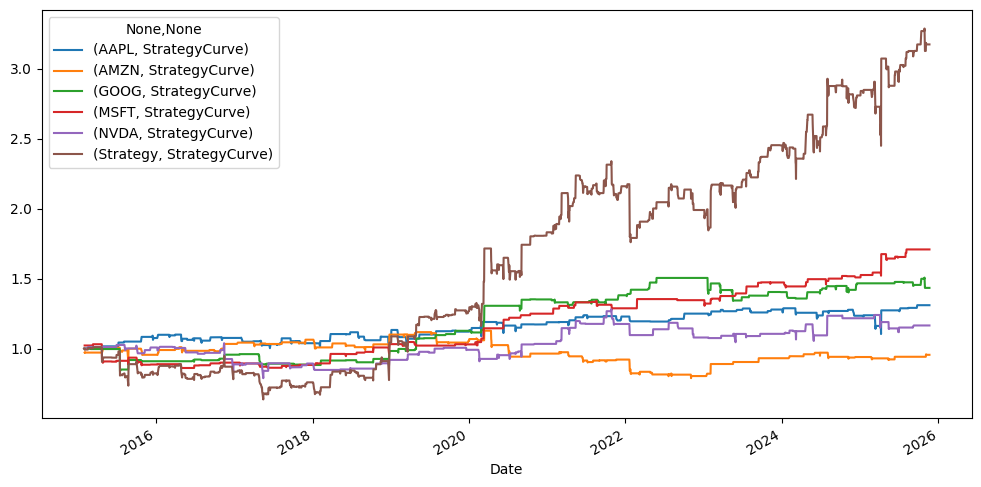

In [169]:
df_backtest.loc[:, idx[: , 'StrategyCurve']].plot(figsize=(12,6))

<Axes: xlabel='Date'>

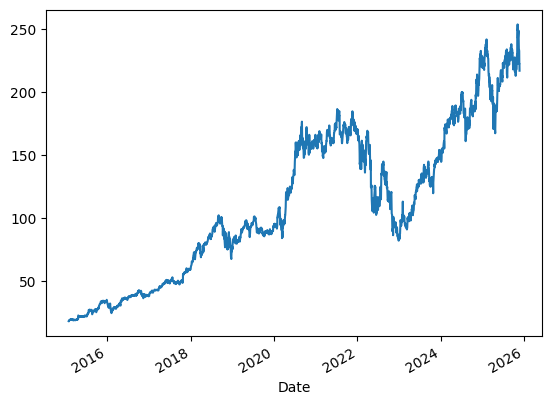

In [128]:
df_backtest.loc[:, idx['AMZN', 'Close']].plot()

<Axes: xlabel='Date'>

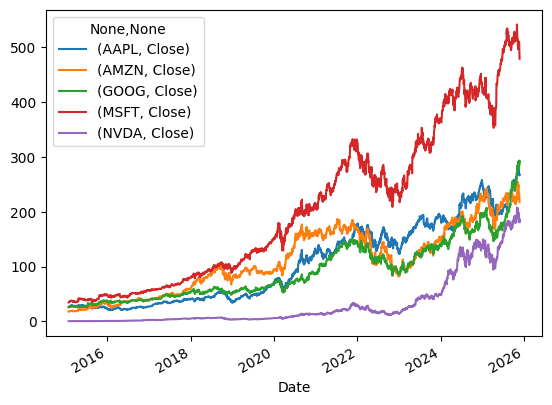

In [132]:
df_backtest.loc[:, idx[:, 'Close']].plot()

In [144]:
df_backtest.loc[:, idx['AMZN', ['ReturnCurve', 'StrategyCurve']]]

AMZN              
           ReturnCurve StrategyCurve
Date                                
2015-01-30         NaN           NaN
2015-02-02    1.028037      0.985981
2015-02-03    1.025442      0.988470
2015-02-04    1.028827      0.985208
2015-02-05    1.054608      0.985208
...                ...           ...
2025-11-14   13.239501      0.812062
2025-11-17   13.136829      0.812062
2025-11-18   12.554650      0.812062
2025-11-19   12.562548      0.812062
2025-11-20   12.249457      0.812062

[2720 rows x 2 columns]

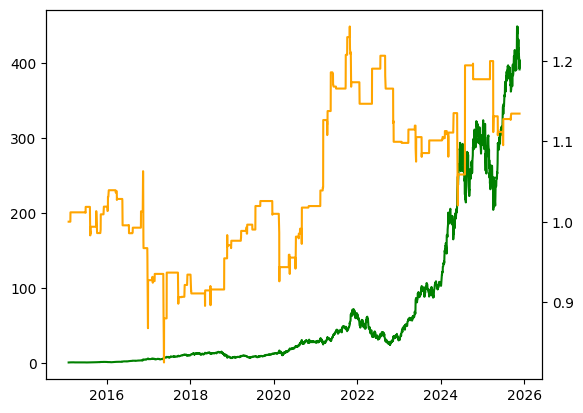

In [160]:
fig, ax = plt.subplots()

ax.plot(df_backtest.loc[:, idx['NVDA', ['ReturnCurve']]], color='green')

ax2 = ax.twinx()
ax2.plot(df_backtest.loc[:, idx['NVDA', ['StrategyCurve']]], color='orange')

plt.show;

<Axes: xlabel='Date'>

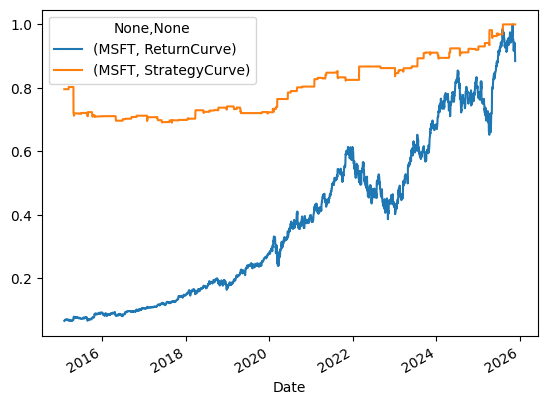

In [148]:
df_backtest.loc[:, idx['MSFT', ['ReturnCurve', 'StrategyCurve']]].div(df_backtest.loc[:, idx['MSFT', ['ReturnCurve', 'StrategyCurve']]].max()).plot()

<Axes: xlabel='Date'>

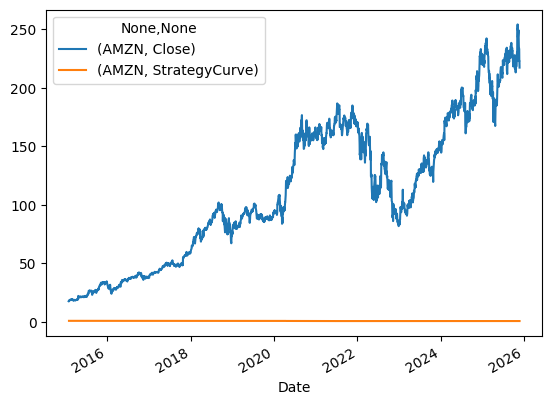

In [138]:
df_backtest.loc[:, idx['AMZN', ['Close', 'StrategyCurve']]].plot()

In [108]:
df_backtest.loc[:, idx[: , ['Signal', 'Position']]].loc['2015-04-22':].head(8)

,AAPL,MSFT,AAPL,MSFT
,Signal,Signal,Position,Position
Date,,,,
2015-04-22,0.0,0.0,0.0,0.0
2015-04-23,0.0,-1.0,0.0,0.0
2015-04-24,0.0,-1.0,0.0,-1.0
2015-04-27,-0.5,-0.5,0.0,-1.0
2015-04-28,0.0,-1.0,-0.5,-0.5
2015-04-29,0.0,-1.0,0.0,-1.0
2015-04-30,0.0,0.0,0.0,-1.0
2015-05-01,0.0,0.0,0.0,0.0


In [109]:
df_backtest.loc[:, idx[: , ['Signal']]].loc['2015-04-22':].head(8)

,AAPL,MSFT
,Signal,Signal
Date,,
2015-04-22,0.0,0.0
2015-04-23,0.0,-1.0
2015-04-24,0.0,-1.0
2015-04-27,-0.5,-0.5
2015-04-28,0.0,-1.0
2015-04-29,0.0,-1.0
2015-04-30,0.0,0.0
2015-05-01,0.0,0.0


In [110]:
df_backtest.loc[:, idx[: , ['Position']]].loc['2015-04-22':].head(8)

,AAPL,MSFT
,Position,Position
Date,,
2015-04-22,0.0,0.0
2015-04-23,0.0,0.0
2015-04-24,0.0,-1.0
2015-04-27,0.0,-1.0
2015-04-28,-0.5,-0.5
2015-04-29,0.0,-1.0
2015-04-30,0.0,-1.0
2015-05-01,0.0,0.0


In [120]:
((df_backtest.loc[:, idx[: , ['Signal']]].loc['2015-04-22':].head(8).values == df_backtest.loc[:, idx[: , ['Position']]].loc['2015-04-22':].head(8).values) == False).any(axis=1)

array([False,  True, False,  True,  True, False,  True, False])

In [ ]:
df_backtest.loc[:, idx[: , ['Signal', 'Position']]].loc['2015-04-22':].head(8).sum(axis=1)

Date
2015-04-22    0.0
2015-04-23   -1.0
2015-04-24   -2.0
2015-04-27   -2.0
2015-04-28   -2.0
2015-04-29   -2.0
2015-04-30   -1.0
2015-05-01    0.0
dtype: float64

In [99]:
df_backtest.groupby(('AAPL', 'Signal')).sum()

AAPL                                             \
                        Close             MA          STD          Upper   
(AAPL, Signal)                                                             
-1.0             10029.280260    9387.667107   280.025710    9947.718528   
-0.5               716.225008     674.107947    16.603128     707.314204   
 0.0            268127.803492  265901.730365  7926.343690  281754.417745   
 0.5              1105.968239    1246.134793    54.030185    1354.195163   
 1.0              6190.618128    6631.636508   188.539354    7008.715216   

                                                                      \
                        Lower            RSI    Return   ReturnCurve   
(AAPL, Signal)                                                         
-1.0              8827.615686    7626.886512  1.720454    386.136736   
-0.5               640.901690     929.386876  0.223198     27.575337   
 0.0            250049.042985  140852.742387  2.580806  10322.172967   
 0.5              1138.074424     309.269577 -0.515007     42.580819   
 1.0              6254.557800    1438.661885 -1.231659    238.344628   

                                     ...        MSFT                           \
               ReturnValue Position  ... ReturnValue Signal Position TradeFee   
(AAPL, Signal)                       ...                                        
-1.0              38613.70    -43.5  ...    56913.28    0.0     -3.5      0.0   
-0.5               2757.53     -4.0  ...     4188.74   -6.0     -4.0      0.0   
 0.0            1032317.37    -21.5  ...  1513353.51  -68.0    -64.5      0.0   
 0.5               4258.10      5.0  ...     6488.04    7.5      4.0      0.0   
 1.0              23834.49     29.5  ...    35036.71    0.0      1.5      0.0   

                                                      Strategy               \
               StrategyGross  Strategy StrategyCurve    Return  ReturnCurve   
(AAPL, Signal)                                                                
-1.0                0.029401  0.029401    105.791075 -0.427994   112.789489   
-0.5               -0.016013 -0.016013     11.803760 -0.075362    12.102163   
 0.0                0.425250  0.425250   2799.409439  1.547672  3008.819175   
 0.5               -0.049377 -0.049377     15.672741 -0.218687    16.380837   
 1.0                0.017449  0.017449     67.420482 -0.267265    72.015694   

                               
                  ReturnValue  
(AAPL, Signal)                 
-1.0             11278.948884  
-0.5              1210.216288  
 0.0            300881.917473  
 0.5              1638.083719  
 1.0              7201.569448  

[5 rows x 32 columns]

In [49]:
df_backtest.loc[:, idx[:, 'StrategyCurve']]

,AAPL,MSFT
,StrategyCurve,StrategyCurve
Date,,
2015-01-30,NaN,NaN
2015-02-02,1.000000,1.021782
2015-02-03,1.000000,1.021782
2015-02-04,1.000000,1.021782
2015-02-05,1.000000,1.021782
...,...,...
2025-11-14,1.130962,1.467551
2025-11-17,1.130962,1.467551


In [81]:
df_backtest.loc['2015-04-22':].loc[:, idx[:, ['Return', 'Signal', 'Position', 'Strategy', 'StrategyCurve']]].sort_index(axis=1, level=0, sort_remaining=False).head(10)

AAPL                                              MSFT         \
              Return Signal Position  Strategy StrategyCurve    Return Signal   
Date                                                                            
2015-04-22  0.013474    0.0      0.0  0.000000      1.000000  0.008209    0.0   
2015-04-23  0.008163    0.0      0.0  0.000000      1.000000  0.008142   -1.0   
2015-04-24  0.004705    0.0      0.0  0.000000      1.000000  0.104522   -1.0   
2015-04-27  0.018191   -0.5      0.0  0.000000      1.000000  0.003343   -0.5   
2015-04-28 -0.015756    0.0     -0.5  0.007878      1.007878  0.023527   -1.0   
2015-04-29 -0.014706    0.0      0.0  0.000000      1.007878 -0.002034   -1.0   
2015-04-30 -0.027130    0.0      0.0  0.000000      1.007878 -0.008561    0.0   
2015-05-01  0.030364    0.0      0.0  0.000000      1.007878  0.000411    0.0   
2015-05-04 -0.001938    0.0      0.0  0.000000      1.007878 -0.008631    0.0   
2015-05-05 -0.022533    0.0      0.0  0.000000      1.007878 -0.013267    0.0   

                                             Strategy  
           Position  Strategy StrategyCurve    Return  
Date                                                   
2015-04-22      0.0  0.000000      1.030750       0.0  
2015-04-23      0.0  0.000000      1.030750       0.0  
2015-04-24     -1.0 -0.104522      0.923014 -0.104522  
2015-04-27     -1.0 -0.003343      0.919928 -0.003343  
2015-04-28     -0.5 -0.011763      0.909107 -0.003886  
2015-04-29     -1.0  0.002034      0.910956  0.002034  
2015-04-30     -1.0  0.008561      0.918755  0.008561  
2015-05-01      0.0  0.000000      0.918755       0.0  
2015-05-04      0.0  0.000000      0.918755       0.0  
2015-05-05      0.0  0.000000      0.918755       0.0

In [83]:
df_backtest

AAPL                                                \
                 Close          MA       STD       Upper       Lower   
Date                                                                   
2015-01-30   25.973391   24.528299  0.796546   26.121391   22.935206   
2015-02-02   26.299294   24.631386  0.885396   26.402177   22.860595   
2015-02-03   26.303715   24.768835  0.922076   26.612987   22.924683   
2015-02-04   26.505459   24.916260  0.953299   26.822858   23.009661   
2015-02-05   26.694645   25.056628  0.999384   27.055396   23.057860   
...                ...         ...       ...         ...         ...   
2025-11-14  272.410004  268.112178  4.713296  277.538771  258.685585   
2025-11-17  267.459991  268.385876  4.492599  277.371074  259.400679   
2025-11-18  267.440002  268.632101  4.284036  277.200173  260.064030   
2025-11-19  268.559998  269.150116  3.513207  276.176530  262.123702   
2025-11-20  266.250000  269.496187  2.753588  275.003363  263.989010   

                                                                ...  \
                  RSI    Return ReturnCurve ReturnValue Signal  ...   
Date                                                            ...   
2015-01-30  58.434263       NaN         NaN      100.00    0.0  ...   
2015-02-02  66.039709  0.012548    1.012548      101.25    0.0  ...   
2015-02-03  64.899223  0.000168    1.012718      101.27    0.0  ...   
2015-02-04  66.956173  0.007670    1.020485      102.05    0.0  ...   
2015-02-05  75.500212  0.007138    1.027769      102.78    0.0  ...   
...               ...       ...         ...         ...    ...  ...   
2025-11-14  60.984026 -0.001978   10.488042     1048.80    0.0  ...   
2025-11-17  47.135420 -0.018171   10.297462     1029.75    0.0  ...   
2025-11-18  45.384538 -0.000075   10.296692     1029.67    0.0  ...   
2025-11-19  43.885790  0.004188   10.339813     1033.98    0.0  ...   
2025-11-20  41.371129 -0.008601   10.250876     1025.09    0.0  ...   

                  MSFT                                                   \
           ReturnValue Signal Position TradeFee StrategyGross  Strategy   
Date                                                                      
2015-01-30      100.00    1.0      0.0     -0.0           NaN       NaN   
2015-02-02      102.18    0.0      1.0     -0.0      0.021782  0.021782   
2015-02-03      102.97    0.0      0.0     -0.0      0.000000  0.000000   
2015-02-04      103.56    0.0      0.0     -0.0      0.000000  0.000000   
2015-02-05      105.07    0.0      0.0     -0.0      0.000000  0.000000   
...                ...    ...      ...      ...           ...       ...   
2025-11-14     1478.71    0.0      0.0     -0.0      0.000000  0.000000   
2025-11-17     1470.92    0.0      0.0     -0.0     -0.000000  0.000000   
2025-11-18     1431.21    0.0      0.0     -0.0     -0.000000  0.000000   
2025-11-19     1411.88    0.0      0.0     -0.0     -0.000000  0.000000   
2025-11-20     1389.28    0.0      0.0     -0.0     -0.000000  0.000000   

                          Strategy                          
           StrategyCurve    Return ReturnCurve ReturnValue  
Date                                                        
2015-01-30           NaN       0.0         1.0        None  
2015-02-02      1.021782  0.021782    1.021782        None  
2015-02-03      1.021782       0.0    1.021782        None  
2015-02-04      1.021782       0.0    1.021782        None  
2015-02-05      1.021782       0.0    1.021782        None  
...                  ...       ...         ...         ...  
2025-11-14      1.467551       0.0    1.659744        None  
2025-11-17      1.467551       0.0    1.659744        None  
2025-11-18      1.467551       0.0    1.659744        None  
2025-11-19      1.467551       0.0    1.659744        None  
2025-11-20      1.467551       0.0    1.659744        None  

[2720 rows x 33 columns]

In [87]:
df_backtest.loc[:, idx[:, ['Return', 'ReturnCurve']]]

,AAPL,MSFT,Strategy,AAPL,MSFT,Strategy
,Return,Return,Return,ReturnCurve,ReturnCurve,ReturnCurve
Date,,,,,,
2015-01-30,NaN,NaN,0.0,NaN,NaN,1.0
2015-02-02,0.012548,0.021782,0.021782,1.012548,1.021782,1.021782
2015-02-03,0.000168,0.007752,0.0,1.012718,1.029703,1.021782
2015-02-04,0.007670,0.005769,0.0,1.020485,1.035644,1.021782
2015-02-05,0.007138,0.014580,0.0,1.027769,1.050743,1.021782
...,...,...,...,...,...,...
2025-11-14,-0.001978,0.013690,0.0,10.488042,14.787137,1.648718
2025-11-17,-0.018171,-0.005273,0.0,10.297462,14.709170,1.648718


In [ ]:
df_backtest.loc[:, idx['Strategy', 'ReturnCurve']].iloc[0] = 100

Date
2015-01-30         1.0
2015-02-02    1.021782
2015-02-03    1.021782
2015-02-04    1.021782
2015-02-05    1.021782
                ...   
2025-11-14    1.648718
2025-11-17    1.648718
2025-11-18    1.648718
2025-11-19    1.648718
2025-11-20    1.648718
Name: (Strategy, ReturnCurve), Length: 2720, dtype: object

In [91]:
df_backtest.loc[:, idx[:, ['Return', 'StrategyCurve', 'ReturnCurve']]]

,AAPL,MSFT,Strategy,AAPL,MSFT,AAPL,MSFT,Strategy
,Return,Return,Return,StrategyCurve,StrategyCurve,ReturnCurve,ReturnCurve,ReturnCurve
Date,,,,,,,,
2015-01-30,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0
2015-02-02,0.012548,0.021782,0.021782,1.000000,1.021782,1.012548,1.021782,1.021782
2015-02-03,0.000168,0.007752,0.0,1.000000,1.021782,1.012718,1.029703,1.021782
2015-02-04,0.007670,0.005769,0.0,1.000000,1.021782,1.020485,1.035644,1.021782
2015-02-05,0.007138,0.014580,0.0,1.000000,1.021782,1.027769,1.050743,1.021782
...,...,...,...,...,...,...,...,...
2025-11-14,-0.001978,0.013690,0.0,1.130962,1.467551,10.488042,14.787137,1.648718
2025-11-17,-0.018171,-0.005273,0.0,1.130962,1.467551,10.297462,14.709170,1.648718


In [82]:
(1 + df_backtest.loc[:, idx['Strategy', 'Return']]).cumprod()

Date
2015-01-30         1.0
2015-02-02    1.021782
2015-02-03    1.021782
2015-02-04    1.021782
2015-02-05    1.021782
                ...   
2025-11-14    1.648718
2025-11-17    1.648718
2025-11-18    1.648718
2025-11-19    1.648718
2025-11-20    1.648718
Name: (Strategy, Return), Length: 2720, dtype: object

In [80]:
df_backtest.loc['2015-04-22':].loc[:, idx[:,['Return','Strategy']]]

,AAPL,MSFT,Strategy,AAPL,MSFT
,Return,Return,Return,Strategy,Strategy
Date,,,,,
2015-04-22,0.013474,0.008209,0.0,0.000000,0.000000
2015-04-23,0.008163,0.008142,0.0,0.000000,0.000000
2015-04-24,0.004705,0.104522,-0.104522,0.000000,-0.104522
2015-04-27,0.018191,0.003343,-0.003343,0.000000,-0.003343
2015-04-28,-0.015756,0.023527,-0.003886,0.007878,-0.011763
...,...,...,...,...,...
2025-11-14,-0.001978,0.013690,0.0,0.000000,0.000000
2025-11-17,-0.018171,-0.005273,0.0,0.000000,0.000000


In [31]:
df_backtest.loc['2015-04-22':].loc[:, idx[:, ['StrategyCurve']]].prod(axis=1).loc['2015-04-22':].head(10)

Date
2015-04-22    1.030750
2015-04-23    1.030750
2015-04-24    0.923014
2015-04-27    0.919928
2015-04-28    0.916268
2015-04-29    0.918132
2015-04-30    0.925993
2015-05-01    0.925993
2015-05-04    0.925993
2015-05-05    0.925993
dtype: float64

In [ ]:
((df_backtest.loc[:, idx[:, ['Position']]]!=0).sum(axis=1) > 1)[((df_backtest.loc[:, idx[:, ['Position']]]!=0).sum(axis=1) > 1)==True]

### Parameter Optimization